<a href="https://colab.research.google.com/github/smstrzd/IntegratedGradCAM/blob/main/Integrated_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Integrated Grad-CAM

This notebook is to replicate our results on Pascal VOC 2007 dataset as attached in ICASSP21 submission. Open it with **Colab** for quick demo.

In [ ]:
'''
Mount your Drive on Colab instance
'''

from google.colab import drive
drive.mount('/content/drive')

#Load dependencies

We will use [**TorchRay Library**](https://github.com/facebookresearch/TorchRay) by **R. Fong et al.** to load the pre-trained models.

For documentation refer [here](https://facebookresearch.github.io/TorchRay/) 

In [ ]:
'''
Clone the provided **dependency** folder into your Drive,

and change directory into the **TorchRay-master** folder.
'''

%cd '/content/drive/My Drive/dependency/TorchRay-master'

In [ ]:
#@title Install the TorchRay library

import sys
!{sys.executable} -m pip install torchray
!{sys.executable} setup.py install

In [5]:
#@title Import basic libraries

import torch
import torchray
from torchray.attribution.grad_cam import grad_cam
import torchray.benchmark

import torchvision
from torchvision.datasets import VOCDetection

from PIL import Image
import cv2
from time import time
import numpy as np
from matplotlib import  pyplot as plt

#Import Pre-trained Models

In [6]:
#@title Import model {run:'auto'}

model_arch = "resnet50" #@param ['vgg16', 'resnet50']
model=torchray.benchmark.models.get_model(arch=model_arch, dataset="voc", convert_to_fully_convolutional=False)

device = torch.device('cuda:0')
model=model.to(device)

Downloading: "https://dl.fbaipublicfiles.com/torchray/resnet50_voc-9ca920d6.pth.tar" to /root/.cache/torch/hub/checkpoints/resnet50_voc-9ca920d6.pth.tar


# Function definitions

In [7]:
from torchray.attribution.common import get_module, Probe

def gradient_to_grad_cam_saliency(x, baseline=None):
    r"""Convert activation and gradient to a Grad-CAM saliency map.

    The tensor :attr:`x` must have a valid gradient ``x.grad``.
    The function then computes the saliency map :math:`s`: given by:

    .. math::

        s_{n1u} = \max\{0, \sum_{c}x_{ncu}\cdot dx_{ncu}\}

    Args:
        x (:class:`torch.Tensor`): activation tensor with a valid gradient.

    Returns:
        :class:`torch.Tensor`: saliency map.
    """
    if baseline is None:
        baseline = x*0.
    # Apply global average pooling (GAP) to gradient.
    grad_weight = torch.mean(x.grad, (2, 3), keepdim=True)

    # Linearly combine activations and GAP gradient weights.
    saliency_map = torch.sum((x-baseline) * grad_weight, 1, keepdim=True)

    # Apply ReLU to visualization.
    saliency_map = torch.clamp(saliency_map, min=0)

    return saliency_map

In [8]:
class NullContext(object):
  
    def __init__(self):
        r"""Null context.

        This context does nothing.
        """

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        return False

def get_backward_gradient(pred_y, y):
    r"""
    Returns a gradient tensor that is either equal to :attr:`y` (if y is a
    tensor with the same shape as pred_y) or a one-hot encoding in the channels
    dimension.

    :attr:`y` can be either an ``int``, an array-like list of integers,
    or a tensor. If :attr:`y` is a tensor with the same shape as
    :attr:`pred_y`, the function returns :attr:`y` unchanged.

    Otherwise, :attr:`y` is interpreted as a list of class indices. These
    are first unfolded/expanded to one index per batch element in
    :attr:`pred_y` (i.e. along the first dimension). Then, this list
    is further expanded to all spatial dimensions of :attr:`pred_y`.
    (i.e. all but the first two dimensions of :attr:`pred_y`).
    Finally, the function return a "gradient" tensor that is a one-hot
    indicator tensor for these classes.

    Args:
        pred_y (:class:`torch.Tensor`): model output tensor.
        y (int, :class:`torch.Tensor`, list, or :class:`np.ndarray`): target
            label(s) that can be cast to :class:`torch.long`.

    Returns:
        :class:`torch.Tensor`: gradient tensor with the same shape as
            :attr:`pred_y`.
    """

    assert isinstance(pred_y, torch.Tensor)
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, dtype=torch.long, device=pred_y.device)
    assert isinstance(y, torch.Tensor)

    if y.shape == pred_y.shape:
        return y
    assert y.dtype == torch.long

    nspatial = len(pred_y.shape) - 2
    grad = torch.zeros_like(pred_y)
    y = y.reshape(-1, 1, *((1,) * nspatial)).expand_as(grad)
    grad.scatter_(1, y, 1.)
    return grad

def attach_debug_probes(model, debug=False):
    r"""
    Returns an :class:`collections.OrderedDict` of :class:`Probe` objects for
    all modules in the model if :attr:`debug` is ``True``; otherwise, returns
    ``None``.

    Args:
        model (:class:`torch.nn.Module`): a model.
        debug (bool, optional): if True, return an OrderedDict of Probe objects
            for all modules in the model; otherwise returns ``None``.
            Default: ``False``.

    Returns:
        :class:`collections.OrderedDict`: dict of :class:`Probe` objects for
            all modules in the model.
    """
    if not debug:
        return None

    debug_probes = OrderedDict()
    for module_name, module in model.named_modules():
        debug_probe_target = "input" if module_name == "" else "output"
        debug_probes[module_name] = Probe(
            module, target=debug_probe_target)
    return debug_probes

def resize_saliency(tensor, saliency, size, mode):
    """Resize a saliency map.

    Args:
        tensor (:class:`torch.Tensor`): reference tensor.
        saliency (:class:`torch.Tensor`): saliency map.
        size (bool or tuple of int): if a tuple (i.e., (width, height),
            resize :attr:`saliency` to :attr:`size`. If True, resize
            :attr:`saliency: to the shape of :attr:`tensor`; otherwise,
            return :attr:`saliency` unchanged.
        mode (str): mode for :func:`torch.nn.functional.interpolate`.

    Returns:
        :class:`torch.Tensor`: Resized saliency map.
    """
    if size is not False:
        if size is True:
            size = tensor.shape[2:]
        elif isinstance(size, tuple) or isinstance(size, list):
            # width, height -> height, width
            size = size[::-1]
        else:
            assert False, "resize must be True, False or a tuple."
        saliency = F.interpolate(
            saliency, size, mode=mode, align_corners=False)
    return saliency

def saliency(model,
             input,
             target,
             saliency_layer='',
             resize=False,
             resize_mode='bilinear',
             smooth=0,
             context_builder=NullContext,
             gradient_to_saliency=gradient_to_grad_cam_saliency,
             get_backward_gradient=get_backward_gradient,
             debug=False):
    """Apply a backprop-based attribution method to an image.

    The saliency method is specified by a suitable context factory
    :attr:`context_builder`. This context is used to modify the backpropagation
    algorithm to match a given visualization method. This:

    Args:
        model (:class:`torch.nn.Module`): a model.
        input (:class:`torch.Tensor`): input tensor.
        target (int or :class:`torch.Tensor`): target label(s).
        saliency_layer (str or :class:`torch.nn.Module`, optional): name of the
            saliency layer (str) or the layer itself (:class:`torch.nn.Module`)
            in the model at which to visualize. Default: ``''`` (visualize
            at input).
        resize (bool or tuple, optional): if True, upsample saliency map to the
            same size as :attr:`input`. It is also possible to specify a pair
            (width, height) for a different size. Default: ``False``.
        resize_mode (str, optional): upsampling method to use. Default:
            ``'bilinear'``.
        smooth (float, optional): amount of Gaussian smoothing to apply to the
            saliency map. Default: ``0``.
        context_builder (type, optional): type of context to use. Default:
            :class:`NullContext`.
        gradient_to_saliency (function, optional): function that converts the
            pseudo-gradient signal to a saliency map. Default:
            :func:`gradient_to_saliency`.
        get_backward_gradient (function, optional): function that generates
            gradient tensor to backpropagate. Default:
            :func:`get_backward_gradient`.
        debug (bool, optional): if True, also return an
            :class:`collections.OrderedDict` of :class:`Probe` objects for
            all modules in the model. Default: ``False``.

    Returns:
        :class:`torch.Tensor` or tuple: If :attr:`debug` is False, returns a
        :class:`torch.Tensor` saliency map at :attr:`saliency_layer`.
        Otherwise, returns a tuple of a :class:`torch.Tensor` saliency map
        at :attr:`saliency_layer` and an :class:`collections.OrderedDict`
        of :class:`Probe` objects for all modules in the model.
    """

    # Clear any existing gradient.
    if input.grad is not None:
        input.grad.data.zero_()

    # Disable gradients for model parameters.
    orig_requires_grad = {}
    for name, param in model.named_parameters():
        orig_requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    # Set model to eval mode.
    if model.training:
        orig_is_training = True
        model.eval()
    else:
        orig_is_training = False

    # Attach debug probes to every module.
    debug_probes = attach_debug_probes(model, debug=debug)

    # Attach a probe to the saliency layer.
    probe_target = 'input' if saliency_layer == '' else 'output'
    saliency_layer = get_module(model, saliency_layer)
    assert saliency_layer is not None, 'We could not find the saliency layer'
    probe = Probe(saliency_layer, target=probe_target)

    # Do a forward and backward pass.
    with context_builder():
        output = model(input)
        backward_gradient = get_backward_gradient(output, target)
        output.backward(backward_gradient)

    # Get saliency map from gradient.
    saliency_map = gradient_to_saliency(probe.data[0])

    # Resize saliency map.
    saliency_map = resize_saliency(input,
                                   saliency_map,
                                   resize,
                                   mode=resize_mode)

    # Smooth saliency map.
    if smooth > 0:
        saliency_map = imsmooth(
            saliency_map,
            sigma=smooth * max(saliency_map.shape[2:]),
            padding_mode='replicate'
        )

    # Remove probe.
    probe.remove()

    # Restore gradient saving for model parameters.
    for name, param in model.named_parameters():
        param.requires_grad_(orig_requires_grad[name])

    # Restore model's original mode.
    if orig_is_training:
        model.train()

    if debug:
        return saliency_map, debug_probes
    else:
        return saliency_map

def grad_cam(*args,
             saliency_layer,
             **kwargs):
    r"""Grad-CAM method.

    The function takes the same arguments as :func:`.common.saliency`, with
    the defaults required to apply the Grad-CAM method, and supports the
    same arguments and return values.
    """
    return saliency(*args,
                    saliency_layer=saliency_layer,
                    gradient_to_saliency=gradient_to_grad_cam_saliency,
                    **kwargs,)

#Integrated Grad-CAM

In [9]:
def integrated_gradcam(model, input, saliency_layer, target, baseline=None, num_steps=50):

    image_stack = torch.zeros((num_steps, 3, 224, 224))

    if baseline is None:
        baseline = input[0]*0.

    for i in range(num_steps):
        image_stack[i] = baseline + (input[0]-baseline)*(i/num_steps)

    ex_stack=grad_cam(model, image_stack.to(device),
                  saliency_layer=saliency_layer, target=target)
    
    ex=np.sum( ((ex_stack.cpu()).detach()).numpy(), axis = 0 )

    return cv2.resize(ex[0],(224,224))

# Apply on images

In [10]:
#@title Image Build functions

def imread(file, as_pil=False, resize=None, to_rgb=False):
    img = Image.open(file)
    if to_rgb:
        img = img.convert('RGB')
    if resize is not None:
        if not isinstance(resize, tuple) and not isinstance(resize, list):
            scale = float(resize) / float(min(img.size[0], img.size[1]))
            resize = [round(scale * h) for h in img.size]
        if resize != img.size:
            img = img.resize(resize, Image.ANTIALIAS)
    if as_pil:
        return img
    return pil_to_tensor(img)

def pil_to_tensor(pil_image):
    pil_image = np.array(pil_image)
    if len(pil_image.shape) == 2:
        pil_image = pil_image[:, :, None]
    return torch.tensor(pil_image, dtype=torch.float32).permute(2, 0, 1) / 255

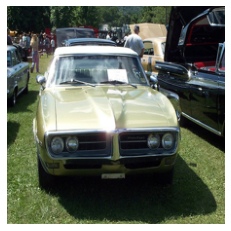

In [13]:
'''
  Load Image
'''

img_path = '/content/drive/My Drive/Images/006757.jpg'  # Provide image path here

image_PIL = Image.open(img_path)
image_torch=imread(img_path, resize=(224, 224), to_rgb=True).unsqueeze(0)
image_torch=image_torch.to(device)

plt.axis('off')
plt.imshow(image_PIL.resize((224,224)));

Available classes in Pascal VOC 2007 dataset along their class ids.

In [14]:
classes=torchray.benchmark.datasets.VOC_CLASSES

for class_id in range(len(classes)):
    print(str(class_id)+' :: '+classes[class_id])

0 :: aeroplane
1 :: bicycle
2 :: bird
3 :: boat
4 :: bottle
5 :: bus
6 :: car
7 :: cat
8 :: chair
9 :: cow
10 :: diningtable
11 :: dog
12 :: horse
13 :: motorbike
14 :: person
15 :: pottedplant
16 :: sheep
17 :: sofa
18 :: train
19 :: tvmonitor


In [15]:
class_id = 6  # Provide class id here

print(f'Chosen class_id : {classes[class_id]}')

Chosen class_id : car


Apply **Integrated Grad-CAM**

Run time: 0.2553527355194092


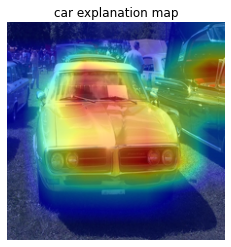

In [16]:
start = time()

exmap=integrated_gradcam(model=model,input=(image_torch*255.),
               saliency_layer='layer4.2', target=class_id, num_steps=50)    
 
print('Run time: ' + str(time()-start))

plt.axis('off')
plt.title(classes[class_id]+' explanation map')
plt.imshow(image_PIL.resize((224,224)))
plt.imshow(exmap, cmap='jet', alpha=0.5);